In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import datetime
import pickle

2024-04-24 10:36:02.313067: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 10:36:06.277948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 10:36:42.393133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [125]:
num_classes = 22
latent_dim = 10
num_channels = 3
generator_channels = latent_dim + num_classes
discriminator_channels = num_classes + num_channels
batch_size = 128
image_size = 128

In [126]:
def load_data(batch_size=batch_size):
    train_data = keras.utils.image_dataset_from_directory("datasets/padded_training",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=(256,256),
                                                            batch_size=batch_size)
    test_data = keras.utils.image_dataset_from_directory("datasets/padded_testing",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=(256,256),
                                                            batch_size=batch_size)
    return train_data, test_data

In [127]:
train_data, test_data = load_data()
combined_data = train_data.concatenate(test_data)

Found 3300 files belonging to 22 classes.
Found 3298 files belonging to 22 classes.


In [128]:
def preprocess(image, label):
    image = ops.image.resize(image, [image_size, image_size])
    return image, label
train_data_resize = (train_data.map(preprocess))

In [129]:
def get_generator_block(filters):
    return keras.Sequential([
        layers.Conv2DTranspose(filters, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        ]
    )

def make_generator(generator_channels):
    return keras.Sequential([
        keras.Input(shape=(generator_channels,)),
        layers.Normalization(),
        layers.Dense(4*4*generator_channels),
        layers.LeakyReLU(),
        layers.Reshape((4, 4, generator_channels)),
        get_generator_block(256),
        get_generator_block(128),
        get_generator_block(64),
        get_generator_block(32),
        get_generator_block(16),
        #get_generator_block(8),
        layers.Conv2D(3, (7,7), padding="same", activation="tanh")
    ])

def get_discriminator_block(size):
    return keras.Sequential([
        layers.Conv2D(size, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
    ])

def make_discriminator(image_size, discriminator_channels):
    return keras.Sequential([
        keras.Input(shape=(image_size, image_size, discriminator_channels)),
        layers.Normalization(),
        get_discriminator_block(3),
        get_discriminator_block(8),
        get_discriminator_block(32),
        get_discriminator_block(64),
        get_discriminator_block(128),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1)
    ])

In [130]:
@keras.saving.register_keras_serializable()
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [132]:
discriminator = make_discriminator(64, discriminator_channels)
discriminator.summary()

Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_21                │ (None, 64, 64, 25)     │            51 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_116 (Sequential)     │ (None, 32, 32, 3)      │         1,215 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_117 (Sequential)     │ (None, 16, 16, 8)      │           424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_118 (Sequential)     │ (None, 8, 8, 32)       │         4,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_119 (Sequential)     │ (None, 4, 4, 64)       │        33,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_120 (Sequential)     │ (None, 2, 2, 128)      │       131,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,875 (667.48 KB)

 Trainable params: 170,354 (665.45 KB)

 Non-trainable params: 521 (2.04 KB)

In [131]:
generator = make_generator(generator_channels)
generator.summary()

Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_20                │ (None, 32)             │            65 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_101 (LeakyReLU)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_110 (Sequential)     │ (None, 8, 8, 256)      │       132,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_111 (Sequential)     │ (None, 16, 16, 128)    │       524,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_112 (Sequential)     │ (None, 32, 32, 64)     │       131,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_113 (Sequential)     │ (None, 64, 64, 32)     │        32,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_114 (Sequential)     │ (None, 128, 128, 16)   │         8,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 128, 128, 3)    │         2,355 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 849,188 (3.24 MB)

 Trainable params: 848,131 (3.24 MB)

 Non-trainable params: 1,057 (4.13 KB)

In [133]:
def run_experiment(discriminator, generator, latent_dim, epochs, learning_rate_d, learning_rate_g, data):
    dt_format = "%Y-%m-%d-%H-%M-%S"
    dt = datetime.datetime.now().strftime(dt_format)
    callbacks_dir = f"callbacks/{dt}"
    callbacks = [
        keras.callbacks.BackupAndRestore(callbacks_dir, save_freq="epoch", delete_checkpoint=False), 
        keras.callbacks.CSVLogger('callbacks/'+dt+'.log')
    ]
    gan = ConditionalGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate_d),
        g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate_g),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    )
    history = gan.fit(data, epochs=epochs, callbacks=callbacks)
    return gan, history

In [134]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, 
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)
discriminator_lr = 1e-6


In [135]:
gan, history = run_experiment(discriminator=discriminator, 
               generator=generator, 
               latent_dim=latent_dim, 
               epochs=1000, 
               learning_rate_d = discriminator_lr, 
               learning_rate_g = lr_schedule, 
               data = train_data_resize)

Epoch 1/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - d_loss: 0.4564 - g_loss: 0.6731
Epoch 2/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - d_loss: 0.6084 - g_loss: 0.4113
Epoch 3/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - d_loss: 0.6786 - g_loss: 0.3322
Epoch 4/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - d_loss: 0.6831 - g_loss: 0.3223
Epoch 5/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - d_loss: 0.6778 - g_loss: 0.3222
Epoch 6/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - d_loss: 0.6741 - g_loss: 0.3237
Epoch 7/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - d_loss: 0.6675 - g_loss: 0.3270
Epoch 8/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - d_loss: 0.6596 - g_loss: 0.3319
Epoch 9/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - d_loss: 0.6496 - g_loss: 0.3376
Epoch 10/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - d_loss: 0.6414 - g_loss: 0.3439
Epoch 11/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - d_loss: 0.6330 - g_loss: 0.3503
Epoch 12/1000
26/26 ━━━━━━━━━━━━━━━━━━━

In [63]:
gan.save("experiments/2024-04-24-11-17-53.keras")

/n/holylfs05/LABS/informatics/Users/lei/conda_envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


In [66]:
gan_1 = keras.models.load_model("experiments/2024-04-24-11-17-53.keras")

TypeError: <class '__main__.ConditionalGAN'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'ConditionalGAN', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'Custom>ConditionalGAN', 'compile_config': {'optimizer': 'rmsprop', 'loss': None, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.ConditionalGAN'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of ConditionalGAN from its config.

Received config={'trainable': True, 'dtype': 'float32'}

Error encountered during deserialization: ConditionalGAN.__init__() got an unexpected keyword argument 'trainable'

In [26]:
import pandas as pd
history = pd.read_csv('callbacks/combined_1k.log')

In [136]:
history = history.history

In [137]:
def plot_history(history, title):
    plt.figure(figsize=(8, 8))
    plt.plot(history['g_loss'], label='Generator')
    plt.plot(history['d_loss'], label='Discriminator')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

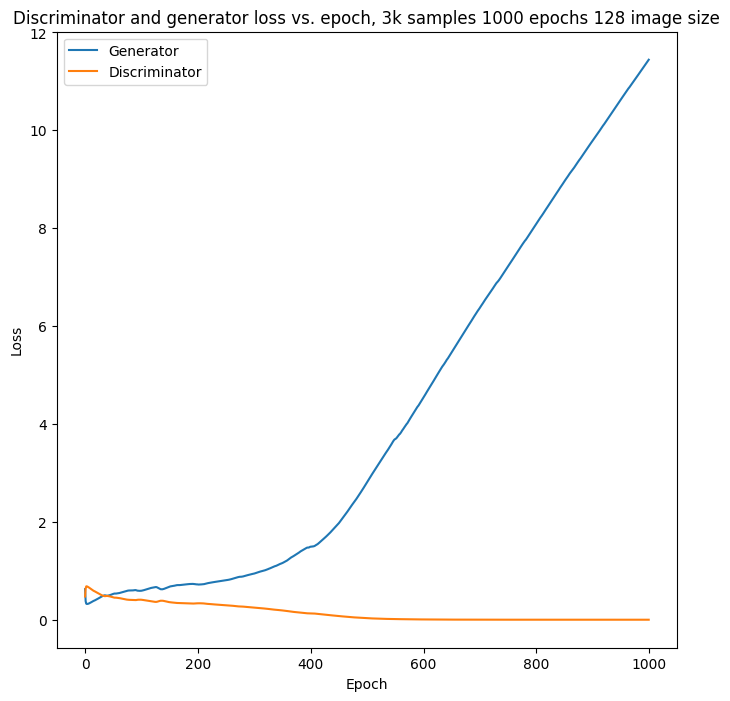

In [141]:
plot_history(history, 'Discriminator and generator loss vs. epoch, 3k samples 1000 epochs '+ str(image_size) +' image size')

In [142]:
noise = keras.random.normal(shape=(1,latent_dim))
noise = ops.repeat(noise, repeats=num_classes)
noise = ops.reshape(noise, (num_classes, latent_dim))

labels = np.arange(num_classes)
labels = keras.utils.to_categorical(labels, num_classes)
noise_and_labels = ops.concatenate([noise, labels], axis=1)

In [143]:
#gan = ConditionalGAN(discriminator=make_discriminator(image_size, discriminator_channels), 
#                     generator=make_generator(generator_channels),
#                     latent_dim=latent_dim)
#gan.load_weights('callbacks/combined_1k/latest.weights.h5')
trained_gen = gan.generator
#fake = trained_gen.predict(noise_and_labels)
fake = trained_gen.predict(noise_and_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


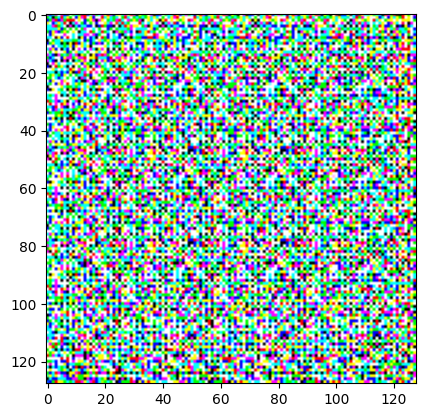

In [144]:
plt.imshow(fake[1])

In [59]:
fake[1]

array([[[ 0.9313457 ,  0.7873828 ,  0.9999993 ],
        [ 1.        ,  0.1261615 ,  0.9991868 ],
        [ 1.        ,  1.        ,  1.        ],
        ...,
        [-1.        , -1.        ,  1.        ],
        [-1.        , -1.        , -1.        ],
        [-0.98008454, -0.99940777, -1.        ]],

       [[ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  0.9879476 ],
        [ 1.        , -0.99604404, -0.991648  ],
        ...,
        [ 1.        ,  0.99999946, -1.        ],
        [-1.        ,  1.        , -1.        ],
        [ 1.        , -0.99999267, -1.        ]],

       [[ 1.        , -1.        , -1.        ],
        [ 1.        ,  1.        , -1.        ],
        [ 1.        ,  1.        , -1.        ],
        ...,
        [-1.        ,  0.99999475, -1.        ],
        [-1.        , -1.        ,  0.9997999 ],
        [ 0.97204345,  1.        , -0.9999009 ]],

       ...,

       [[ 1.        ,  1.        , -1.        ],
        [ 1